In [1]:
import utils
import requests

text_by_file = utils.load_files('./ustawy/*')

for file,text in text_by_file.items():
    text_by_file[file] = ' '.join(text.split())

1. Read the classification of [Named Entities](https://clarin-pl.eu/dspace/bitstream/handle/11321/294/WytyczneKPWr-jednostkiidentyfikacyjne.pdf).
1. Read the [API of NER](https://wiki.clarin-pl.eu/pl/nlpws/services/liner2) in [Clarin](https://ws.clarin-pl.eu/ner.shtml).
1. Read the [documentation of CCL format](https://wiki.clarin-pl.eu/pl/nlpws/services/ccl) or [more tourough documentation of CCL format](http://nlp.pwr.wroc.pl/redmine/projects/corpus2/wiki/CCL_format).
1. Sort bills according to their size and take top 50 (largest) bills.

In [4]:
text_sorted = {k: v for k, v in sorted(text_by_file.items(), key=lambda item: len(item[1]), reverse=True)[:50]}
text_sorted.keys()

dict_keys(['./ustawy/2000_696.txt', './ustawy/2001_627.txt', './ustawy/1996_465.txt', './ustawy/2002_1689.txt', './ustawy/1997_555.txt', './ustawy/1998_1118.txt', './ustawy/2000_1186.txt', './ustawy/2003_2277.txt', './ustawy/2003_1750.txt', './ustawy/2001_1070.txt', './ustawy/2001_499.txt', './ustawy/1997_117.txt', './ustawy/2004_2065.txt', './ustawy/2001_1368.txt', './ustawy/2004_1693.txt', './ustawy/2001_1229.txt', './ustawy/2000_1268.txt', './ustawy/1997_926.txt', './ustawy/1994_195.txt', './ustawy/2001_1545.txt', './ustawy/2004_880.txt', './ustawy/2004_177.txt', './ustawy/2003_423.txt', './ustawy/2000_1104.txt', './ustawy/1997_714.txt', './ustawy/1997_553.txt', './ustawy/1997_349.txt', './ustawy/1994_591.txt', './ustawy/2004_2533.txt', './ustawy/2001_1381.txt', './ustawy/1999_930.txt', './ustawy/2000_1315.txt', './ustawy/2000_136.txt', './ustawy/1999_95.txt', './ustawy/1996_460.txt', './ustawy/2003_2256.txt', './ustawy/1997_557.txt', './ustawy/1996_110.txt', './ustawy/1996_561.txt'

In [69]:
import shutil

for file in text_sorted.keys():
    shutil.copy(file, 'ustawy_top_50')


5. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive
   words starting with a capital letter (you will have to look at the inflected form of the word to check its
   capitalization) that do not occupy the first position in a sentence. E.g. the sentence:
   ```
   Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.
   ```
   should yield the following entries: `Kraków`, `Polska`, `Stan Zjednoczony`.

In [90]:
lem_files = ['./ustawy_lem/' + '%'.join(f.split('/')[1:]) for f in text_sorted.keys()]

In [91]:
import xml.etree.ElementTree as ET
import glob

def parse_xml(path: str) -> list[str]:
    tree = ET.parse(path)
    root = tree.getroot()

    sentences = []
    
    for chunk in root.iter('chunk'):
        sentences.append(list(chunk.iter('sentence')))
    
    return sentences

def parse_files(paths: list[str]) -> dict[str, str]:
    files = []

    for file in paths:
        files.append(parse_xml(file))

    return files

files_xml = parse_files(lem_files)

In [92]:
def find_ne_in_sentence(sentence):
    nes = []
    ne = ''
    toks = list(sentence.iter('tok'))
    for tok in toks[1:]:
        orth = tok.find('orth').text
        base = tok.find('lex').find('base').text
        if (orth[0].isupper() or (ne != '' and orth == '.')) and orth not in ['Art','Poz']:
            ne += base + ' '
        elif ne != '':
            nes.append(ne)
            ne = ''
    return nes


In [93]:
nes = [ne for chunk in files_xml for sentences in chunk for sentence in sentences for ne in find_ne_in_sentence(sentence)]
nes[:10]

['u . ',
 'Dzieje_(Apostolskie) . u . ',
 'minister ',
 'Dzieje_(Apostolskie) . u . nr ',
 'minister sprawa wewnętrzny ',
 'minister ',
 'minister sprawa wewnętrzny ',
 'minister ',
 'prawa ',
 'Dzieje_(Apostolskie) . u . nr ']

6. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [94]:
from collections import Counter

nes_freq = Counter(nes)

a = sorted(nes_freq.items(), key=lambda item: item[1], reverse=True)[:50]
print(a)

[('nr ', 4125), ('rzeczpospolita polski ', 587), ('Dzieje_(Apostolskie) . u . nr ', 543), ('kodeks ', 522), ('dziennik . u . ', 391), ('policja ', 384), ('Dzieje_(Apostolskie) . u . ', 378), ('skarb państwo ', 320), ('prawo ', 298), ('unia europejski ', 291), ('kasa chora ', 261), ('straż graniczny ', 258), ('minister ', 255), ('prezes urząd ', 242), ('zmiana ', 205), ('państwowy straż pożarny ', 201), ('zakład ', 196), ('pozostały ', 179), ('rad minister ', 170), ('fundusz ', 165), ('sprawiedliwość ', 163), ('państwowy komisja wyborczy ', 161), ('rad ', 157), ('obrona narodowy ', 156), ('w ', 152), ('urząd patentowy ', 152), ('EFTA ', 151), ('minister sprawiedliwość ', 144), ('europejski porozumienie ', 141), ('Wolny handel ', 140), ('tkanina ', 138), ('minister obrona narodowy ', 136), ('europejski obszar gospodarczy ', 128), ('finanse ', 115), ('SKW ', 115), ('i ', 113), ('urząd ', 110), ('dziennik . u . nr ', 105), ('przepis ', 102), ('komisja ', 101), ('biuro ', 98), ('inspektor n

'rzeczpospolita polski' i 'Rzeczpospolita Polska' - z jakiegoś powodu w zależności od przypadku 'Polski' we frazie jest ona przez Clarin traktowana inaczej: 

'Rzeczpospolitej Polskiej' -> 'rzeczpospolita polski'

'Rzeczpospolita Polska', 'Rzeczpospolitą Polską' -> 'Rzeczpospolita Polska'

przykład [`ustawy%2004_963.txt`](./ustawy_lem/ustawy%252004_963.txt)

7. Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the `n82` model.

In [ ]:
from lpmn_client import download_file, upload_file
from lpmn_client import Task

# not working, use web page instead
task = Task(lpmn='any2txt|wcrft2|liner2({"model":"n82"})')
task.email = "pawel.kopel2@gmail.com"  # change e-mail

file_id = upload_file("./ustawy_top_50.zip")
output_file_id = task.run(file_id)
download_file(output_file_id, "./ustawy_top_50_nes")

In [74]:
def parse_xml2(path: str) -> list[str]:
    tree = ET.parse(path)
    root = tree.getroot()

    nes = []
    ne = []
    
    for tok in root.iter('tok'):
        lex = tok.find('lex')
        base = lex.find('base').text
        ann = tok.find('ann')
        if ann is not None:
            if (ann.text == '0' or 'head' in ann.attrib.keys()) and len(ne) > 0:
                nes.append(ne)
                ne = []
            if ann.text != '0':
                ne.append((base, ann.attrib['chan']))
        elif len(ne) > 0:
            nes.append(ne)
            ne = []
            
    
    return nes

def parse_files2(path: str) -> dict[str, str]:
    files = []

    for file in glob.glob(path):
        files.append(parse_xml2(file))

    return files

files_xml = parse_files2('./ustawy_top_50_lem/*')

In [75]:
files_xml[0]

[[('Dzieje_(Apostolskie)', 'nam_pro_media_periodic'),
  ('.', 'nam_pro_media_periodic'),
  ('u', 'nam_pro_media_periodic'),
  ('.', 'nam_pro_media_periodic')],
 [('kodeks', 'nam_org_institution'), ('celny', 'nam_org_institution')],
 [('przepis', 'nam_org_institution'), ('ogólny', 'nam_org_institution')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('rada', 'nam_org_institution'), ('minister', 'nam_org_institution')],
 [('Dzieje_(Apostolskie)', 'nam_pro_media_periodic'),
  ('.', 'nam_pro_media_periodic'),
  ('u', 'nam_pro_media_periodic'),
  ('.', 'nam_pro_media_periodic')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('prezes', 'nam_o

In [76]:
nes_cl = [ne for file_nes in files_xml for ne in file_nes]
nes_cl[:10]

[[('Dzieje_(Apostolskie)', 'nam_pro_media_periodic'),
  ('.', 'nam_pro_media_periodic'),
  ('u', 'nam_pro_media_periodic'),
  ('.', 'nam_pro_media_periodic')],
 [('kodeks', 'nam_org_institution'), ('celny', 'nam_org_institution')],
 [('przepis', 'nam_org_institution'), ('ogólny', 'nam_org_institution')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')],
 [('polski', 'nam_adj_country')]]

8. Plot the frequency (histogram) of the coarse-grained classes (e.g. `nam_adj`, `nam_eve`, `nam_fac`).

270
19
59


<BarContainer object of 3 artists>

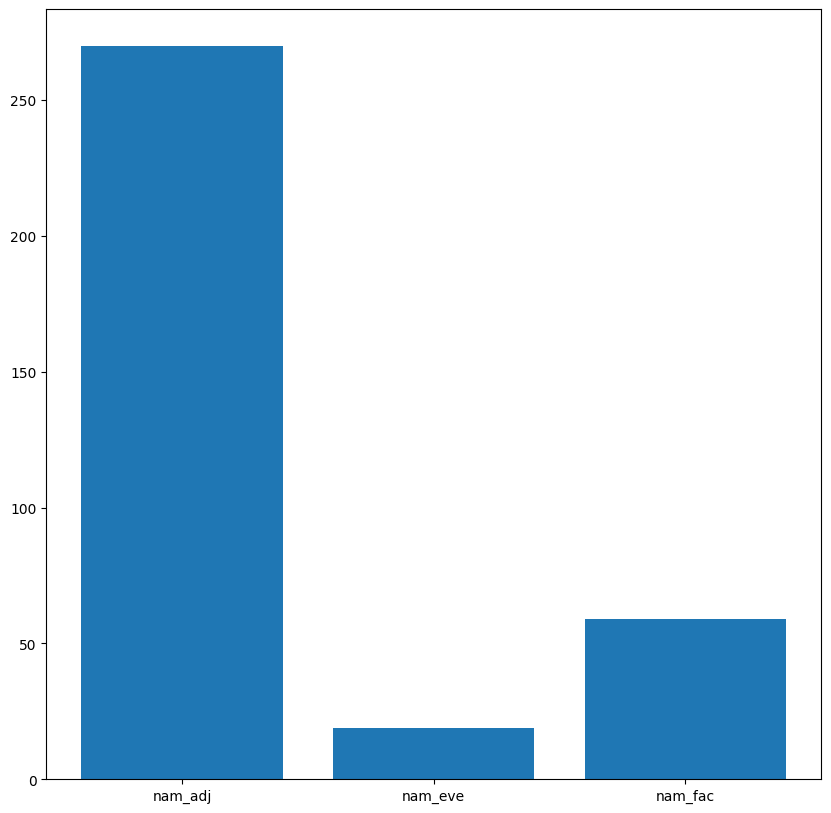

In [79]:
import matplotlib.pyplot as plt

nam_adjs = list(filter(lambda ne: 'nam_adj' in ne[0][1], nes_cl))
nam_eves = list(filter(lambda ne: 'nam_eve' in ne[0][1], nes_cl))
nam_facs = list(filter(lambda ne: 'nam_fac' in ne[0][1], nes_cl))

print(len(nam_adjs))
print(len(nam_eves))
print(len(nam_facs))

plt.figure(figsize=(10,10))

labels = ['nam_adj','nam_eve','nam_fac']
values = [len(nam_adjs), len(nam_eves), len(nam_facs)]
plt.bar(labels, values)

9. Display 10 most frequent Named Entities for each coarse-grained type.

In [84]:
def merge_nes(nes):
    nes2 = []
    for l in nes:
        ne = ''
        type = ''
        for w,t in l:
            type = t
            ne += w + ' '
        nes2.append((ne,type))
    return nes2

top_10_adjs = sorted(Counter(merge_nes(nam_adjs)).items(), key=lambda item: item[1], reverse=True)[:10]

top_10_adjs

[(('polski ', 'nam_adj_country'), 186),
 (('wojewódzki ', 'nam_adj_country'), 20),
 (('europejski ', 'nam_adj_other'), 8),
 (('unijny ', 'nam_adj_other'), 6),
 (('internetowy ', 'nam_adj_other'), 3),
 (('macierzyński ', 'nam_adj_country'), 3),
 (('krośnieński ', 'nam_adj_country'), 2),
 (('kolbuszowski ', 'nam_adj_country'), 2),
 (('warszawski ', 'nam_adj_city'), 2),
 (('afrykański ', 'nam_adj_country'), 2)]

In [85]:
sorted(Counter(merge_nes(nam_eves)).items(), key=lambda item: item[1], reverse=True)[:10]

[(('euro ', 'nam_eve_human_sport'), 4),
 (('maksymalny limit pozostałość ', 'nam_eve_human'), 2),
 (('przejściowy plan krajowy ', 'nam_eve_human'), 2),
 (('oddział 2 tranzyt ', 'nam_eve_human'), 1),
 (('monitor sądowy ', 'nam_eve_human_sport'), 1),
 (('wojna poległy ', 'nam_eve_other'), 1),
 (('X . opieka domowy nad dziecko ', 'nam_eve_human'), 1),
 (('generalny konserwator zabytek ', 'nam_eve_human'), 1),
 (('maksymalny limit pozostałość ', 'nam_eve_human_sport'), 1),
 (('kodeks morski ', 'nam_eve_human'), 1)]

In [86]:
sorted(Counter(merge_nes(nam_facs)).items(), key=lambda item: item[1], reverse=True)[:10]

[(('inspektor nadzór wewnętrzny ', 'nam_fac_goe'), 24),
 (('komendant główny ', 'nam_fac_goe'), 10),
 (('krajowy rejestr karny ', 'nam_fac_goe'), 5),
 (('zatoka gdańska ', 'nam_fac_goe'), 3),
 (('kościół adwentysta dzień siódmy ', 'nam_fac_goe'), 2),
 (('straż graniczny ', 'nam_fac_goe'), 2),
 (('krajowy rad sądownictwo ', 'nam_fac_road'), 2),
 (('X ', 'nam_fac_goe'), 2),
 (('dzienia wojska polski ', 'nam_fac_goe'), 1),
 (('wspólny słownik zamówienie ', 'nam_fac_goe'), 1)]

10. Display 50 most frequent Named Entities including their count and fine-grained type.

In [87]:
sorted(Counter(merge_nes(nes_cl)).items(), key=lambda item: item[1], reverse=True)[:50]

[(('rzeczpospolita polski ', 'nam_loc_gpe_country'), 550),
 (('Dzieje_(Apostolskie) . u . ', 'nam_pro_media_periodic'), 412),
 (('skarb państwo ', 'nam_org_institution'), 368),
 (('złoty ', 'nam_oth_currency'), 329),
 (('minister sprawiedliwość ', 'nam_org_institution'), 306),
 (('minister obrona narodowy ', 'nam_org_institution'), 299),
 (('rada minister ', 'nam_org_institution'), 260),
 (('prezes urząd ', 'nam_org_institution'), 246),
 (('dziennik . u . ', 'nam_pro_media_periodic'), 217),
 (('unia europejski ', 'nam_org_organization'), 208),
 (('prezes rad minister ', 'nam_org_institution'), 203),
 (('minister finanse ', 'nam_org_institution'), 198),
 (('urząd patentowy ', 'nam_org_institution'), 189),
 (('polski ', 'nam_adj_country'), 186),
 (('państwowy komisja wyborczy ', 'nam_org_institution'), 156),
 (('SKW ', 'nam_org_organization'), 123),
 (('państwowy straż pożarny ', 'nam_org_organization'), 118),
 (('państwowy ', 'nam_org_institution'), 105),
 (('komisja wyborczy ', 'nam_or

11. Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color.
   (For demo application [Streamlit](https://streamlit.io/) might be useful for displaying NER results).

In [96]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [102]:
def parse_files3(path: str) -> dict[str, str]:

    sentences = []

    for file in glob.glob(path):
        tree = ET.parse(file)
        root = tree.getroot()

        sentences = []

        for sentence in root.iter('sentence'):
            tokens = list(sentence.iter('tok'))
            if len(list(tokens[0].iter('ann'))) > 1:
                sentences.append(tokens)
            
            if len(sentences) == 5:
                break  
        else:
            continue  # only executed if the inner loop did NOT break
        break

    return sentences

files_xml = parse_files3('./ustawy_top_50_lem/*')

In [113]:
for sentence in files_xml:
    types = list(map(lambda ann: ann.attrib['chan'], list(sentence[0].iter('ann'))))
    colors = {t:c for t,c in zip(types,['red', 'green', 'blue'])}
    for t,c in colors.items():
        printmd(f"<span style='color:{c}'>{t}</span>")
    
    output = ''
    for tok in sentence:
        tok_color = None
        tok_orth = tok.find('orth').text 
        
        for ann in tok.iter('ann'):
            if ann.text != '0':
                tok_color = colors[ann.attrib['chan']]
        
        output += f'{tok_orth} ' if tok_color is None else f"<span style='color:{tok_color}'>{tok_orth}</span> "
    printmd(output)
    

<span style='color:red'>nam_adj_country</span>

<span style='color:green'>nam_org_institution</span>

<span style='color:blue'>nam_loc_gpe_country</span>

Nr 106 , poz . 496 ) , 12 ) plafon taryfowy - określoną ilość lub wartość towarów w przywozie na <span style='color:red'>polski</span> obszar celny lub w ich wywozie poza <span style='color:red'>polski</span> obszar celny , dla których <span style='color:green'>Rada</span> <span style='color:green'>Ministrów</span> ustaliła obniżone stawki celne ; określona ilość lub wartość towarów może być realizowana , a nawet przekroczona przed terminem zamknięcia ( zamknięcie plafonu ) , 13 ) <span style='color:red'>polski</span> obszar celny - terytorium <span style='color:blue'>Rzeczypospolitej</span> <span style='color:blue'>Polskiej</span> , 14 ) przedstawienie towarów organowi celnemu - zawiadomienie organu celnego przez osobę , dokonane w wymaganej formie , o dostarczeniu towarów do urzędu celnego albo miejsca wyznaczonego lub uznanego przez organ celny , 15 ) rewizja celna - ustalenie rodzaju , ilości , stanu towaru oraz w razie potrzeby , ocena wartości celnej towaru , 16 ) status celny - określenie towaru jako towaru krajowego lub niekrajowego , 17 ) środki polityki handlowej - ustanowione w ramach polityki gospodarczej państwa pozataryfowe środki , takie 

<span style='color:red'>nam_adj_country</span>

<span style='color:green'>nam_org_institution</span>

Przeznaczenie celne to : 1 ) objęcie towaru procedurą celną , 2 ) wprowadzenie towaru do wolnego obszaru celnego lub do składu wolnocłowego , 3 ) powrotny wywóz towaru poza <span style='color:red'>polski</span> obszar celny , 4 ) zniszczenie towaru , 5 ) zrzeczenie się towaru na rzecz <span style='color:green'>Skarbu</span> <span style='color:green'>Państwa</span> . 

<span style='color:red'>nam_loc_gpe_country</span>

<span style='color:green'>nam_org_institution</span>

Rewizji celnej nie podlegają : 1 ) na zasadzie wzajemności : a ) towary przeznaczone dla obcych przedstawicielstw dyplomatycznych , urzędów konsularnych oraz misji specjalnych w <span style='color:red'>Rzeczypospolitej</span> <span style='color:red'>Polskiej</span> , a także organizacji międzynarodowych mających siedziby lub placówki w <span style='color:red'>Rzeczypospolitej</span> <span style='color:red'>Polskiej</span> , b ) towary przeznaczone dla osób korzystających z przywilejów i immunitetów dyplomatycznych , c ) opatrzone pieczęcią przesyłki urzędowe przesyłane do obcych przedstawicielstw dyplomatycznych , urzędów konsularnych i misji specjalnych w <span style='color:red'>Rzeczypospolitej</span> <span style='color:red'>Polskiej</span> oraz opatrzone pieczęcią przesyłki przez nie wysyłane , 2 ) opatrzone pieczęcią przesyłki urzędowe przesyłane między <span style='color:green'>Ministerstwem</span> <span style='color:green'>Spraw</span> <span style='color:green'>Zagranicznych</span> <span style='color:red'>Rzeczypospolitej</span> <span style='color:red'>Polskiej</span> a polskimi przedstawicielstwami dyplomatycznymi , urzędami konsularnymi i misjami specjalnymi za granicą . 

<span style='color:red'>nam_loc_gpe_country</span>

<span style='color:green'>nam_org_organization</span>

Taryfa celna obejmuje : 1 ) <span style='color:red'>Polską</span> <span style='color:green'>Scaloną</span> <span style='color:green'>Nomenklaturę</span> <span style='color:green'>Towarową</span> <span style='color:green'>Handlu</span> <span style='color:green'>Zagranicznego</span> <span style='color:green'>PCN</span> ( nomenklatura towarowa ) , 2 ) stawki celne , sposób , warunki i zakres ich stosowania , 3 ) jednostki miar , 4 ) obniżone stawki celne określone w umowach zawartych przez <span style='color:red'>Rzeczpospolitą</span> <span style='color:red'>Polską</span> z niektórymi krajami lub grupami krajów , 5 ) preferencyjne stawki celne przyjęte jednostronnie przez <span style='color:red'>Rzeczpospolitą</span> <span style='color:red'>Polską</span> w odniesieniu do niektórych krajów , grup krajów lub regionów . 

<span style='color:red'>nam_org_institution</span>

<span style='color:green'>nam_pro_title</span>

<span style='color:blue'>nam_loc_gpe_country</span>

<span style='color:red'>Prezes</span> <span style='color:red'>Głównego</span> <span style='color:red'>Urzędu</span> <span style='color:red'>Ceł</span> ogłasza , w formie zarządzenia , w <span style='color:red'>Dzienniku</span> <span style='color:red'>Urzędowym</span> <span style='color:blue'>Rzeczypospolitej</span> <span style='color:blue'>Polskiej</span> <span style='color:red'>"</span> <span style='color:green'>Monitor</span> <span style='color:green'>Polski</span> " , wyjaśnienia do taryfy celnej . 

12. Answer the following questions:
      1. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with
         identification of the proper names?
      1. What are the drawbacks of the method based on capital letters?
      1. What are the drawbacks of the method based on NER?
      1. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this
         observation.
      1. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and
         "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that
         would be able to group such names together?
      1. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition
         algorithm?